In [1]:
import os
import gc
import pickle
from datetime import datetime, date, timedelta
import holidays

import numpy as np
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import mean_absolute_error
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import VotingRegressor

import lightgbm as lgb

import optuna

In [2]:
def feature_eng(df_data, df_client, df_gas, df_electricity, df_forecast, df_historical, df_location, df_target):
    df_data = (
        df_data
        .with_columns(
            pl.col("datetime").cast(pl.Date).alias("date"),
        )
    )
    
    df_client = (
        df_client
        .with_columns(
            (pl.col("date") + pl.duration(days=2)).cast(pl.Date)
        )
    )
    
    df_gas = (
        df_gas
        .rename({"forecast_date": "date"})
        .with_columns(
            (pl.col("date") + pl.duration(days=1)).cast(pl.Date)
        )
    )
    
    df_electricity = (
        df_electricity
        .rename({"forecast_date": "datetime"})
        .with_columns(
            pl.col("datetime") + pl.duration(days=1)
        )
    )
    
    df_location = (
        df_location
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32)
        )
    )
    
    df_forecast = (
        df_forecast
        .rename({"forecast_datetime": "datetime"})
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32),
        )
        .join(df_location, how="left", on=["longitude", "latitude"])
        .drop("longitude", "latitude")
    )
    
    df_historical = (
        df_historical
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32),
        )
        .join(df_location, how="left", on=["longitude", "latitude"])
        .drop("longitude", "latitude")
    )
    
    df_forecast_date = (
        df_forecast
        .group_by("datetime").mean()
        .drop("county")
    )
    
    df_forecast_local = (
        df_forecast
        .filter(pl.col("county").is_not_null())
        .group_by("county", "datetime").mean()
    )
    
    df_historical_date = (
        df_historical
        .filter(pl.col('datetime').dt.hour() <= 10).with_columns(pl.col("datetime") + pl.duration(days=1))
        .with_columns(pl.col("datetime").cast(pl.Date).alias("date"))
        .group_by('date').mean() # .sort('datetime')
        .drop("county","datetime")
    )
    
    df_historical_local = (
        df_historical
        .filter(pl.col('datetime').dt.hour() <= 10).with_columns(pl.col("datetime") + pl.duration(days=1))
        .with_columns(pl.col("datetime").cast(pl.Date).alias("date"))
        .group_by('date','county').mean() # .sort('date')
        .drop("datetime")
    )

    
    df_data = (
        df_data
        .join(df_gas, on="date", how="left")
        .join(df_client, on=["county", "is_business", "product_type", "date"], how="left")
        .join(df_electricity, on="datetime", how="left")
        
        .join(df_forecast_date, on="datetime", how="left", suffix="_fd")
        .join(df_forecast_local, on=["county", "datetime"], how="left", suffix="_fl")
        # .join(df_historical_date, on="date", how="left", suffix="_hd")
        # .join(df_historical_local, on=["county", "date"], how="left", suffix="_hl")
        
        # .join(df_forecast_date.with_columns(pl.col("datetime") + pl.duration(days=7)), on="datetime", how="left", suffix="_fdw")
        # .join(df_forecast_local.with_columns(pl.col("datetime") + pl.duration(days=7)), on=["county", "datetime"], how="left", suffix="_flw")
        # .join(df_historical_date.with_columns(pl.col("date") + pl.duration(days=7)), on="date", how="left", suffix="_hdw")
        # .join(df_historical_local.with_columns(pl.col("date") + pl.duration(days=7)), on=["county", "date"], how="left", suffix="_hlw")
        
        .join(df_target.with_columns(pl.col("datetime") + pl.duration(days=2)).rename({"target": "target_1"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
        .join(df_target.with_columns(pl.col("datetime") + pl.duration(days=3)).rename({"target": "target_2"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
        .join(df_target.with_columns(pl.col("datetime") + pl.duration(days=4)).rename({"target": "target_3"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
        .join(df_target.with_columns(pl.col("datetime") + pl.duration(days=5)).rename({"target": "target_4"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
        .join(df_target.with_columns(pl.col("datetime") + pl.duration(days=6)).rename({"target": "target_5"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
        .join(df_target.with_columns(pl.col("datetime") + pl.duration(days=7)).rename({"target": "target_6"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
        .join(df_target.with_columns(pl.col("datetime") + pl.duration(days=14)).rename({"target": "target_7"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
        
        .with_columns(
            pl.col("datetime").dt.ordinal_day().alias("dayofyear"),
            pl.col("datetime").dt.hour().alias("hour"),
            pl.col("datetime").dt.day().alias("day"),
            pl.col("datetime").dt.weekday().alias("weekday"),
            pl.col("datetime").dt.month().alias("month"),
            pl.col("datetime").dt.year().alias("year"),
        )
        
        # .with_columns(
            # pl.concat_str("county", "is_business", "product_type", "is_consumption", separator="_").alias("category_1"),
        # )
        
        .with_columns(
            (np.pi * pl.col("dayofyear") / 183).sin().alias("sin(dayofyear)"),
            (np.pi * pl.col("dayofyear") / 183).cos().alias("cos(dayofyear)"),
            (np.pi * pl.col("hour") / 12).sin().alias("sin(hour)"),
            (np.pi * pl.col("hour") / 12).cos().alias("cos(hour)"),
        )
        
        .with_columns(
            pl.col(pl.Float64).cast(pl.Float32),
        )
        
        .drop("hour", "dayofyear", "datetime") # date
    )
    
    return df_data

In [3]:
def to_pandas(X, y=None):
    cat_cols = ["county", "product_type", "is_consumption"] # "category_1", "is_business"
    
    if y is not None:
        df = pd.concat([X.to_pandas(), y.to_pandas()], axis=1)
    else:
        df = X.to_pandas()    
    
    df = df.set_index("row_id")
    df[cat_cols] = df[cat_cols].astype("category")
    
    df["target_mean"] = df[[f"target_{i}" for i in range(1, 7)]].mean(1)
    df["target_std"] = df[[f"target_{i}" for i in range(1, 7)]].std(1)
    df["target_ratio"] = df["target_6"] / (df["target_7"] + 1e-3)
    
    return df

## Read Data

In [4]:
root = "/kaggle/input/predict-energy-behavior-of-prosumers"

data_cols        = ['target', 'county', 'is_business', 'product_type', 'is_consumption', 'datetime', 'row_id']
client_cols      = ['product_type', 'county', 'eic_count', 'installed_capacity', 'is_business', 'date']
gas_cols         = ['forecast_date', 'lowest_price_per_mwh', 'highest_price_per_mwh']
electricity_cols = ['forecast_date', 'euros_per_mwh']
forecast_cols    = ['latitude', 'longitude', 'hours_ahead', 'temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_total', '10_metre_u_wind_component', '10_metre_v_wind_component', 'forecast_datetime', 'direct_solar_radiation', 'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation']
historical_cols  = ['datetime', 'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure','cloudcover_total','cloudcover_low','cloudcover_mid','cloudcover_high','windspeed_10m','winddirection_10m','shortwave_radiation','direct_solar_radiation','diffuse_radiation','latitude','longitude']
location_cols    = ['longitude', 'latitude', 'county']
target_cols      = ['target', 'county', 'is_business', 'product_type', 'is_consumption', 'datetime']

save_path = None
load_path = None

In [5]:
df_data        = pl.read_csv(os.path.join(root, "train.csv"), columns=data_cols, try_parse_dates=True)
df_client      = pl.read_csv(os.path.join(root, "client.csv"), columns=client_cols, try_parse_dates=True)
df_gas         = pl.read_csv(os.path.join(root, "gas_prices.csv"), columns=gas_cols, try_parse_dates=True)
df_electricity = pl.read_csv(os.path.join(root, "electricity_prices.csv"), columns=electricity_cols, try_parse_dates=True)
df_forecast    = pl.read_csv(os.path.join(root, "forecast_weather.csv"), columns=forecast_cols, try_parse_dates=True)
df_historical  = pl.read_csv(os.path.join(root, "historical_weather.csv"), columns=historical_cols, try_parse_dates=True)
df_location    = pl.read_csv(os.path.join(root, "weather_station_to_county_mapping.csv"), columns=location_cols, try_parse_dates=True)
df_target      = df_data.select(target_cols)

schema_data        = df_data.schema
schema_client      = df_client.schema
schema_gas         = df_gas.schema
schema_electricity = df_electricity.schema
schema_forecast    = df_forecast.schema
schema_historical  = df_historical.schema
schema_target      = df_target.schema

In [6]:
pd.set_option('display.max_columns', None)
X, y = df_data.drop("target"), df_data.select("target")
X = feature_eng(X, df_client, df_gas, df_electricity, df_forecast, df_historical, df_location, df_target)
df_train = to_pandas(X, y)

In [7]:
#est_holidays = holidays.EST()
#def add_public_holidays(date):
#    if date in est_holidays:
#        return 1
#    else:
#        return 0
#df_train['is_public_holiday'] = df_train['date'].apply(add_public_holidays)

In [8]:
df_train = df_train[(df_train.year>=2023) & (df_train.target.notna())].reset_index(drop=True)
df_aux = df_train.copy()

# Dummies
dum_cols = ["county", "product_type"] # "is_business"
dummies = pd.get_dummies(df_train[dum_cols], drop_first=True) # drop_first
df_train = pd.concat([df_train, dummies], axis=1)
df_train = df_train.drop(dum_cols, axis=1)

In [9]:
df_train_cons = df_train[df_train.is_consumption==1].copy()

df_train_prod = df_train[df_train.is_consumption==0].copy()
# df_train_prod["target_1_2_grow"] = np.where(df_train_prod['target_2'] == 0, 0, (df_train_prod['target_1'] - df_train_prod['target_2']) / df_train_prod['target_2'])
# df_train_prod["target_1_2_diff"] = df_train_prod["target_2"] - df_train_prod["target_1"]
# df_train_prod["target_1_capacity"] = df_train_prod["target_1"] / df_train_prod["installed_capacity"]
df_train_prod["target_1_2_ratio"] = np.where(df_train_prod['target_2'] == 0, 0, df_train_prod['target_1'] / df_train_prod['target_2'])
df_train_prod["capacity_per_eic"] = df_train_prod["installed_capacity"] / df_train_prod["eic_count"]
df_train_prod = df_train_prod.drop(["installed_capacity","eic_count", "highest_price_per_mwh"], axis=1)

## Dealing Nulls
* **df_client (eic_count i installed_capacity):** 
    * client 2_1_1_0/1 té dades a taula train, però no a taula df_client per 2 dies anteriors (pel mateix dia si). Per 01/01/2022 té a taula train i client, però no per 30/12/2021 a client.
    * client 10_1_2_0/1 té dades fins 27/02/23 i torna a tindre a partir del 05/05/23 amb una capacity més gran. Passa el mateix, el train té dades per al dia 6/5/23 i 5/5/23, però no creuen perquè a df_client anem a buscar les del 4/5/23 i 3/5/23 i no estàn.
* **df_electricity (euros_per_mwh)**: com vam dir, null en 266 casos. Hi ha dies que no hi ha valor. Vam dir d'omplir amb mitjana.
* **df_forecast**: no hi ha forecast per al client 12_1_3_0/1. County 12 és desconegut. És l'únic client pel county 12. De vegades hi ha null a forecast perquè no hi ha dada per aquella hora.
* **df_historical**: només nulls al county 12.
* **target_1:7**: alguns nulls degut a que alguns targets son nulls.

In [10]:
nulls = df_train.isna().sum()
print("Null columns: ", ", ".join(nulls[nulls>0].index))

Null columns:  eic_count, installed_capacity, euros_per_mwh, hours_ahead_fl, temperature_fl, dewpoint_fl, cloudcover_high_fl, cloudcover_low_fl, cloudcover_mid_fl, cloudcover_total_fl, 10_metre_u_wind_component_fl, 10_metre_v_wind_component_fl, direct_solar_radiation_fl, surface_solar_radiation_downwards_fl, snowfall_fl, total_precipitation_fl, target_1, target_2, target_3, target_4, target_5, target_6, target_7, target_mean, target_std, target_ratio


## Baseline Model

In [11]:
from xgboost import XGBRegressor

class TestModelsWithTimeSplits:
    
    def __init__(self, data, train_days_before:int, test_date, target='consumption'):
        self.data = data[data['is_consumption']==1] if target=='consumption' else data[data['is_consumption']==0]
        self.train_days_before = train_days_before
        self.test_date = test_date
        self.train_data = self.get_train_data()
        self.test_data = self.get_test_data()
        # self.model = XGBRegressor()
        self.model = lgb.LGBMRegressor()
    
    def get_train_data(self):
        first_date = self.test_date - timedelta(days=self.train_days_before)
        train_data = self.data[(self.data['date']>= pd.to_datetime(first_date)) & (self.data['date']< pd.to_datetime(self.test_date))]
        return train_data
    
    def get_test_data(self):
        test_data = self.data[self.data['date']==pd.to_datetime(self.test_date)]
        return test_data

    def X_y_split(self):
        X_train = self.train_data.drop(['target', 'date', 'is_consumption'],axis=1)
        y_train = self.train_data['target']
        X_test = self.test_data.drop(['target','date', 'is_consumption'],axis=1)
        y_test = self.test_data['target']
        return X_train, y_train, X_test, y_test
    
    def fit(self, X_train, y_train):
        self.model.fit(X_train, y_train)
        return self
        
    def predict(self, X_test):
        return self.model.predict(X_test)
    

### Train days before

In [12]:
from tqdm import tqdm

mae_days_before_cons = []
for i in tqdm(range(1,60)):
    test_model = TestModelsWithTimeSplits(data=df_train_cons, train_days_before=i, test_date=date(2023,5,31), target='consumption')
    X_train, y_train, X_test, y_test = test_model.X_y_split()
    test_model.fit(X_train, y_train)
    probs = test_model.predict(X_test)
    mae_days_before_cons.append(mean_absolute_error(y_test, probs))

100%|██████████| 59/59 [02:02<00:00,  2.07s/it]


Best days:  51
Value:  41.90658200310935


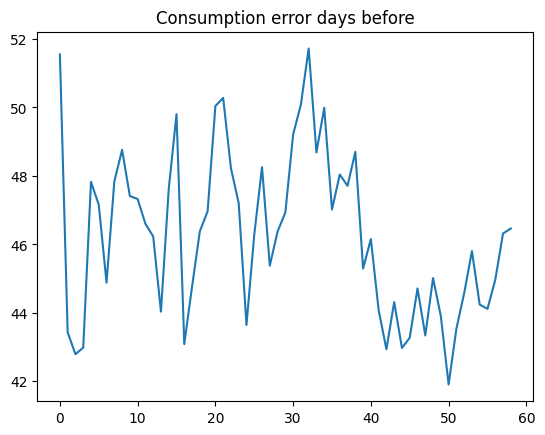

In [13]:
print("Best days: ", mae_days_before_cons.index(min(mae_days_before_cons))+1)
print("Value: ", min(mae_days_before_cons))
plt.plot(mae_days_before_cons)
plt.title("Consumption error days before")
plt.show()

In [14]:
mae_days_before_prod = []
for i in tqdm(range(1,60)):
    test_model = TestModelsWithTimeSplits(data=df_train_prod, train_days_before=i, test_date=date(2023,5,31), target='production')
    X_train, y_train, X_test, y_test = test_model.X_y_split()
    test_model.fit(X_train, y_train)
    probs = test_model.predict(X_test)
    mae_days_before_prod.append(mean_absolute_error(y_test, probs))

100%|██████████| 59/59 [01:56<00:00,  1.98s/it]


Best days:  44
Value:  62.07221455573041


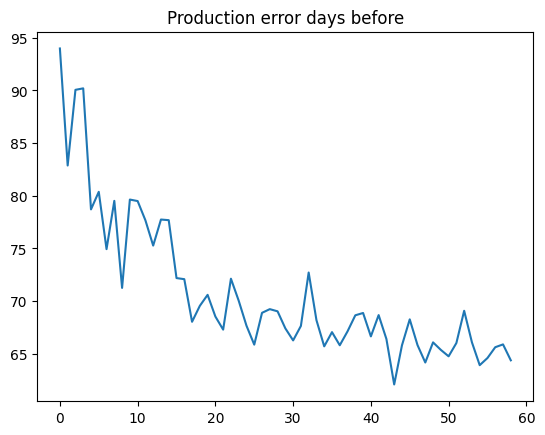

In [15]:
print("Best days: ", mae_days_before_prod.index(min(mae_days_before_prod))+1)
print("Value: ", min(mae_days_before_prod))
plt.title("Production error days before")
plt.plot(mae_days_before_prod)
plt.show()

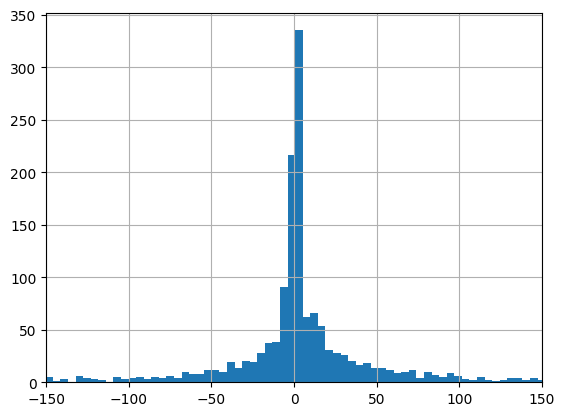

In [16]:
# Error distribution
results = pd.DataFrame({'y_test':y_test,'pred':probs, 'diff':probs-y_test})
results['diff'].hist(bins=1000)
plt.xlim(-150, 150)
plt.show()

## Feature Engineering

* Features temporals ja afegides
* Estonian Holidays
* Features separades per is_business
* Mean gas price
* Ratios, segmentació, ...
* Mitjana d'algo respecte algo
* with no historical, production is much better and consumption equal

## Mutual Information

In [17]:
df_train_cons = df_aux[df_aux['is_consumption']==1].reset_index(drop=True).drop("is_consumption", axis=1)
df_train_prod = df_aux[df_aux['is_consumption']==0].reset_index(drop=True).drop("is_consumption", axis=1)

In [18]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [19]:
df_train_prod.head()

,county,is_business,product_type,date,lowest_price_per_mwh,highest_price_per_mwh,eic_count,installed_capacity,euros_per_mwh,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation,hours_ahead_fl,temperature_fl,dewpoint_fl,cloudcover_high_fl,cloudcover_low_fl,cloudcover_mid_fl,cloudcover_total_fl,10_metre_u_wind_component_fl,10_metre_v_wind_component_fl,direct_solar_radiation_fl,surface_solar_radiation_downwards_fl,snowfall_fl,total_precipitation_fl,target_1,target_2,target_3,target_4,target_5,target_6,target_7,day,weekday,month,year,sin(dayofyear),cos(dayofyear),sin(hour),cos(hour),target,target_mean,target_std,target_ratio
0,0,0,1,2023-01-01,74.0,86.199997,417.0,4001.080078,2.0,35.0,5.092503,4.157948,0.938069,0.741888,0.844411,0.991078,5.298185,4.087361,0.0,0.0,0.0,0.000111,35.0,5.1643,4.600814,0.774271,0.756655,0.980081,0.99656,4.360873,3.215323,0.0,0.0,0.0,0.000236,0.004,0.005,0.006,0.003,0.006,0.005,0.003,1,7,1,2023,0.017166,0.999853,0.0,1.0,0.004,0.004833,0.001169,1.250000
1,0,0,2,2023-01-01,74.0,86.199997,24.0,91.500000,2.0,35.0,5.092503,4.157948,0.938069,0.741888,0.844411,0.991078,5.298185,4.087361,0.0,0.0,0.0,0.000111,35.0,5.1643,4.600814,0.774271,0.756655,0.980081,0.99656,4.360873,3.215323,0.0,0.0,0.0,0.000236,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1,7,1,2023,0.017166,0.999853,0.0,1.0,0.000,0.000000,0.000000,0.000000
2,0,0,3,2023-01-01,74.0,86.199997,1235.0,12543.110352,2.0,35.0,5.092503,4.157948,0.938069,0.741888,0.844411,0.991078,5.298185,4.087361,0.0,0.0,0.0,0.000111,35.0,5.1643,4.600814,0.774271,0.756655,0.980081,0.99656,4.360873,3.215323,0.0,0.0,0.0,0.000236,1.323,1.796,0.460,1.031,0.755,0.973,0.245,1,7,1,2023,0.017166,0.999853,0.0,1.0,1.078,1.056333,0.463081,3.955284
3,0,1,0,2023-01-01,74.0,86.199997,22.0,910.500000,2.0,35.0,5.092503,4.157948,0.938069,0.741888,0.844411,0.991078,5.298185,4.087361,0.0,0.0,0.0,0.000111,35.0,5.1643,4.600814,0.774271,0.756655,0.980081,0.99656,4.360873,3.215323,0.0,0.0,0.0,0.000236,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1,7,1,2023,0.017166,0.999853,0.0,1.0,0.000,0.000000,0.000000,0.000000
4,0,1,1,2023-01-01,74.0,86.199997,96.0,2714.899902,2.0,35.0,5.092503,4.157948,0.938069,0.741888,0.844411,0.991078,5.298185,4.087361,0.0,0.0,0.0,0.000111,35.0,5.1643,4.600814,0.774271,0.756655,0.980081,0.99656,4.360873,3.215323,0.0,0.0,0.0,0.000236,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1,7,1,2023,0.017166,0.999853,0.0,1.0,0.000,0.000000,0.000000,0.000000


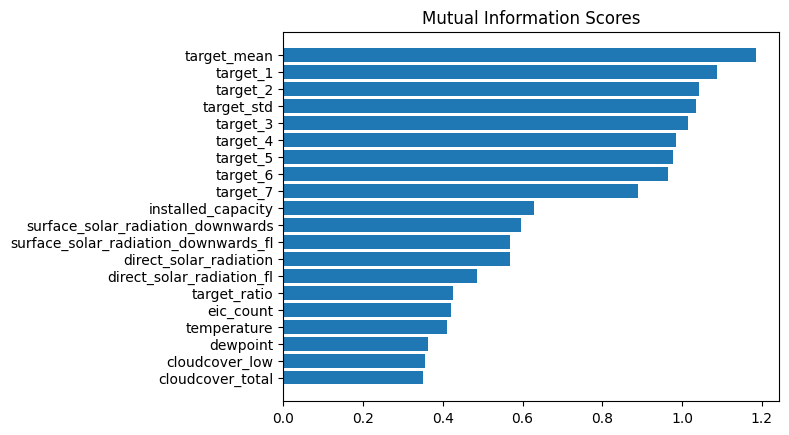

In [20]:
mi_scores = make_mi_scores(df_train_prod.drop(["target","date"], axis=1).fillna(0), df_train_prod["target"])
plot_mi_scores(mi_scores.head(20))

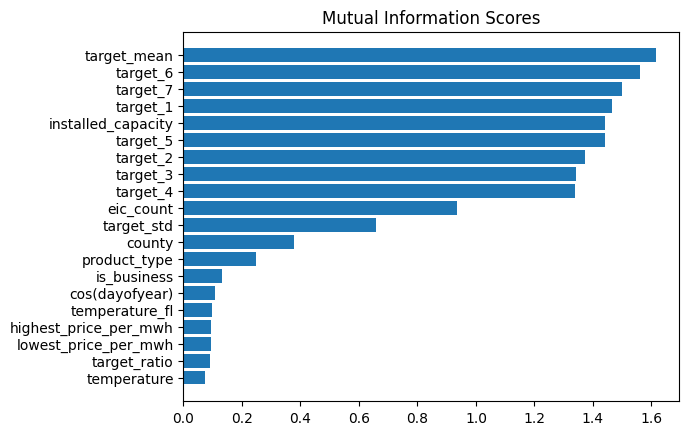

In [21]:
mi_scores = make_mi_scores(df_train_cons.drop(["target","date"], axis=1).fillna(0), df_train_cons["target"])
plot_mi_scores(mi_scores.head(20))

### Plots

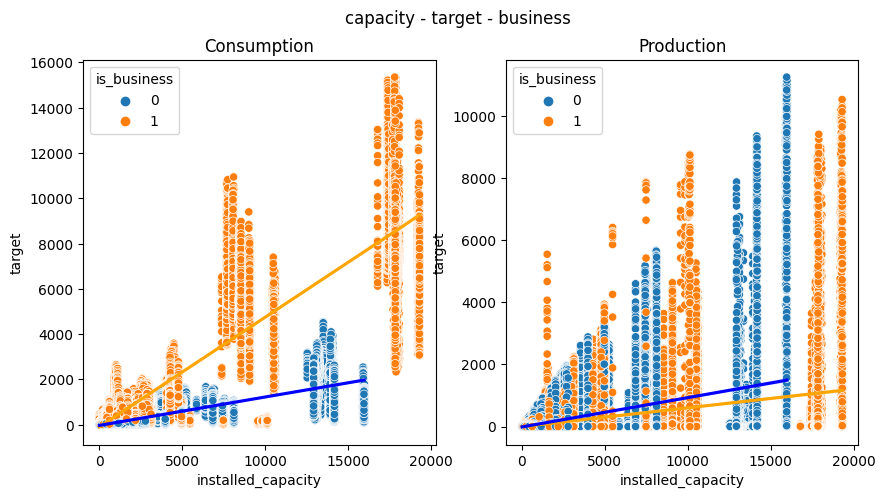

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
fig.suptitle('capacity - target - business')
sns.scatterplot(x=df_train_cons.installed_capacity, y=df_train_cons.target, hue=df_train_cons.is_business, ax=ax1)
sns.regplot(data=df_train_cons[df_train_cons.is_business==1], x='installed_capacity', y='target', scatter=False, color='orange', order=1, label='Trendline', ax=ax1)
sns.regplot(data=df_train_cons[df_train_cons.is_business==0], x='installed_capacity', y='target', scatter=False, color='blue', order=1, label='Trendline', ax=ax1)
ax1.set_title("Consumption")
ax1.set_xlabel("installed_capacity")
ax1.set_ylabel("target")
sns.scatterplot(x=df_train_prod.installed_capacity, y=df_train_prod.target, hue=df_train_prod.is_business, ax=ax2)
sns.regplot(data=df_train_prod[df_train_prod.is_business==1], x='installed_capacity', y='target', scatter=False, color='orange', order=1, label='Trendline', ax=ax2)
sns.regplot(data=df_train_prod[df_train_prod.is_business==0], x='installed_capacity', y='target', scatter=False, color='blue', order=1, label='Trendline', ax=ax2)
ax2.set_title("Production")
ax2.set_xlabel("installed_capacity")
plt.show()

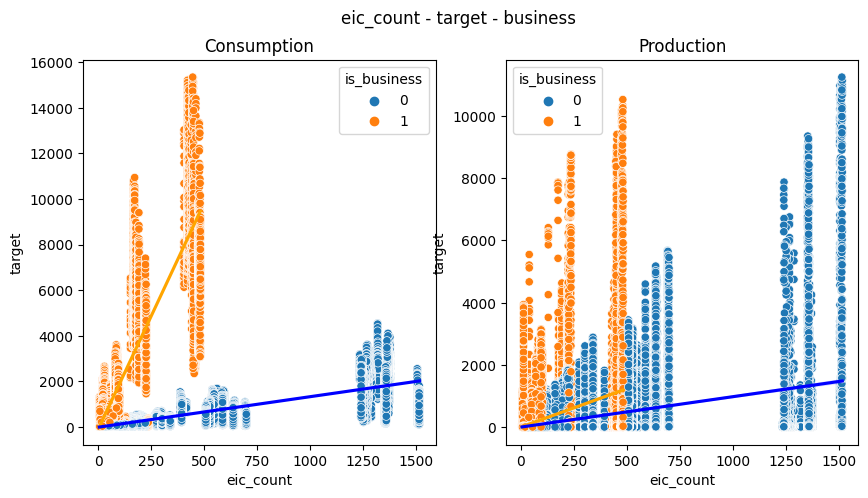

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
fig.suptitle('eic_count - target - business')
sns.scatterplot(x=df_train_cons.eic_count, y=df_train_cons.target, hue=df_train_cons.is_business, ax=ax1)
sns.regplot(data=df_train_cons[df_train_cons.is_business==1], x='eic_count', y='target', scatter=False, color='orange', order=1, label='Trendline', ax=ax1)
sns.regplot(data=df_train_cons[df_train_cons.is_business==0], x='eic_count', y='target', scatter=False, color='blue', order=1, label='Trendline', ax=ax1)
ax1.set_title("Consumption")
ax1.set_xlabel("eic_count")
ax1.set_ylabel("target")
sns.scatterplot(x=df_train_prod.eic_count, y=df_train_prod.target, hue=df_train_prod.is_business, ax=ax2)
sns.regplot(data=df_train_prod[df_train_prod.is_business==1], x='eic_count', y='target', scatter=False, color='orange', order=1, label='Trendline', ax=ax2)
sns.regplot(data=df_train_prod[df_train_prod.is_business==0], x='eic_count', y='target', scatter=False, color='blue', order=1, label='Trendline', ax=ax2)
ax2.set_title("Production")
ax2.set_xlabel("eic_count")
plt.show()

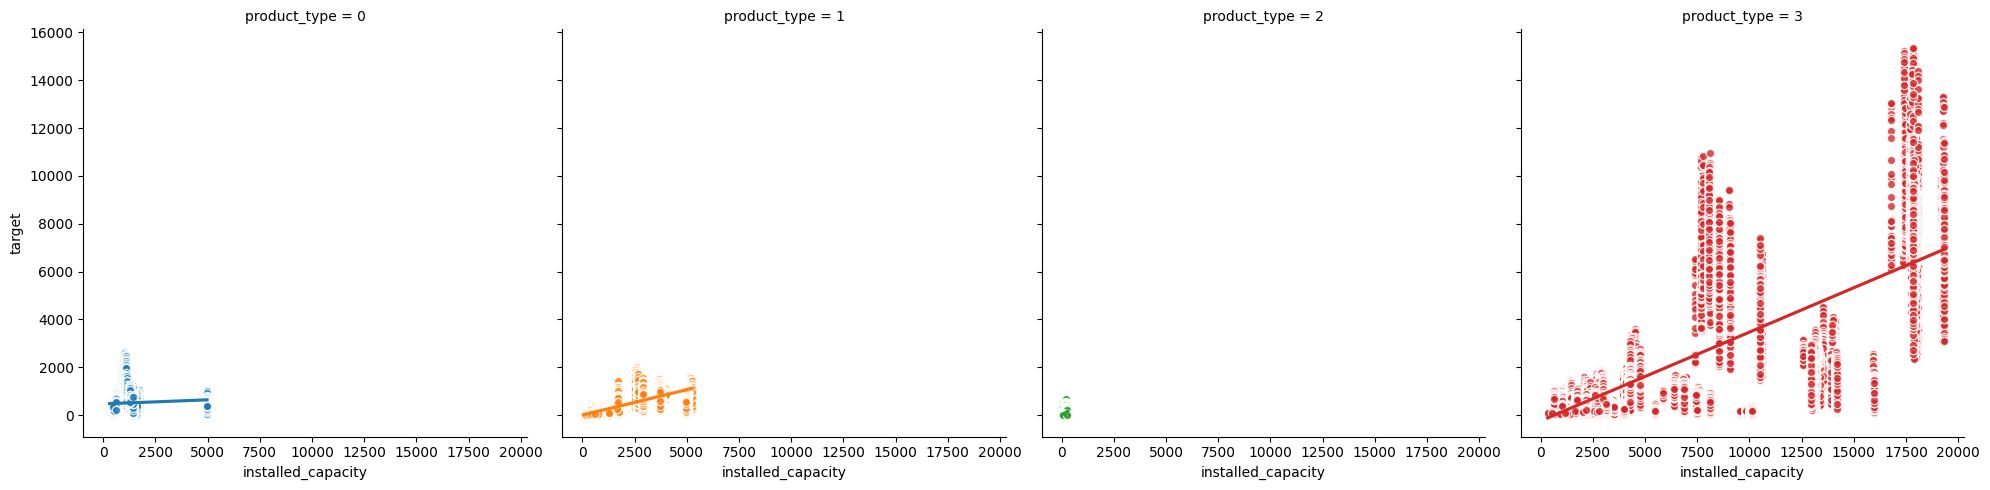

In [24]:
# Relation between capacity and target by product type
sns.lmplot(x="installed_capacity", y="target", hue="product_type", col="product_type", data=df_train_cons, scatter_kws={"edgecolor": 'w'})
plt.show()